In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import skimage.io as io
import skimage.transform as trans
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
import matplotlib.gridspec as gridspec
%matplotlib inline

def normalizeImage(img):
    if np.max(img) > 1:
        img = img/255
    return img

def normalizeMask(mask):
    if np.max(mask) > 1:
        mask = mask/255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return mask
    
## load and check data
image_train_arr = []
mask_train_arr = []

#load avaialble training data
for i in range(0,30):
    img = io.imread("../data/membrane/train/image/{}.png".format(i))
    img = normalizeImage(img)
    mask = io.imread("../data/membrane/train/mask/{}.png".format(i))
    mask = normalizeMask(mask)
    image_train_arr.append(img)
    mask_train_arr.append(mask)

xtrainImage = np.array(image_train_arr)
xtrainImage = xtrainImage.reshape(-1, 512, 512, 1)
xtrainMask = np.array(mask_train_arr)
xtrainMask = xtrainMask.reshape(-1, 512, 512, 1)
print(xtrainImage.shape)
print(xtrainMask.shape)

#io.imshow(xtrainImage[1].reshape(512, 512))
#io.imshow(xtrainMask[1].reshape(512, 512))

Using TensorFlow backend.


(30, 512, 512, 1)
(30, 512, 512, 1)


In [19]:
class uNet:
    def __init__(self, unet_name = "unet"):
        self.c1f = 3
        self.c1n = 64
        self.c2f = 3
        self.c2n = 64
        
        self.c3f = 3
        self.c3n = 128
        self.c4f = 3
        self.c4n = 128
        
        self.c5f = 3
        self.c5n = 256
        self.c6f = 3
        self.c6n = 256
        
        self.c7f = 3
        self.c7n = 512
        self.c8f = 3
        self.c8n = 512
        
        self.c9f = 3
        self.c9n = 1024
        self.c10f = 3
        self.c10n = 1024
        
        self.learn_rate = 0.0001
        
        self.mb_size = 1
        self.perm_array = np.array([])
        self.batch_start_index = 0
        self.batch_end_index = 0
    
    def get_next_mini_batch(self):
        start = self.batch_start_index
        self.batch_end_index = start + self.mb_size
        
        if start == 0:
            self.perm_array = np.arange(len(self.x_train))
            np.random.shuffle(self.perm_array)
            
        if self.batch_end_index > self.x_train.shape[0]:
            np.random.shuffle(self.perm_array)
            start = 0
            self.batch_end_index = start + self.mb_size
        
        end = self.batch_end_index
        self.batch_start_index += self.mb_size
        
        x_tr = self.x_train[self.perm_array[start:end]]
        y_tr = self.y_train[self.perm_array[start:end]]
        
        return x_tr,y_tr
    
    def conv2D(self, x, W):
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME") #NHWC input format
    
    def deConv2D(self, x, output, filter_size, stride):
        return tf.layers.conv2d_transpose(x, output, filter_size, stride, padding="same")
    
    def weight_init(self, shape):
        xavier_std = tf.sqrt(2. / (shape[0]*shape[1]))
        initial = tf.random_normal(shape, stddev = xavier_std)
        return tf.Variable(initial)
    
    def bias_init(self, shape):
        bias = tf.constant(0.1, shape=shape)
        return tf.Variable(bias)
    
    def maxpool2D(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
        
    def create_graph(self):
        
        self.x = tf.placeholder(tf.float32, shape=[None, 512, 512, 1])
        self.y = tf.placeholder(tf.float32, shape=[None, 512, 512, 1])
        
        ##Downsampling
        #========================== First and Second Convolution==============================
        self.c1w = self.weight_init([self.c1f, self.c1f, 1, self.c1n]) #[3, 3, 1, 64]
        self.c1b = self.bias_init([self.c1n]) #[64]
        self.f1 = tf.nn.relu(self.conv2D(self.x, self.c1w) + self.c1b)#[-1, 512, 512, 64]
        print(self.f1.shape)
        
        self.c2w = self.weight_init([self.c2f, self.c2f, self.c1n, self.c2n]) #[3, 3, 64, 64]
        self.c2b = self.bias_init([self.c2n]) #[64]
        self.f2 = tf.nn.relu(self.conv2D(self.f1, self.c2w) + self.c2b)#[-1, 512, 512, 64]
        print(self.f2.shape)
        
        self.max_pool_1 = self.maxpool2D(self.f2)#[-1, 256, 256, 64]
        
        #========================== Third and Fourth Convolution==============================
        self.c3w = self.weight_init([self.c3f, self.c3f, self.c2n, self.c3n]) #[3, 3, 64, 128]
        self.c3b = self.bias_init([self.c3n]) #[128]
        self.f3 = tf.nn.relu(self.conv2D(self.max_pool_1, self.c3w) + self.c3b)#[-1, 256, 256, 128]
        print(self.f3.shape)
        
        self.c4w = self.weight_init([self.c4f, self.c4f, self.c3n, self.c4n]) #[3, 3, 128, 128]
        self.c4b = self.bias_init([self.c4n]) #[128]
        self.f4 = tf.nn.relu(self.conv2D(self.f3, self.c4w) + self.c4b)#[-1, 256, 256, 128]
        print(self.f4.shape)
        
        self.max_pool_2 = self.maxpool2D(self.f4)#[-1, 128, 128, 128]
        
        #========================== Fifth and Sixth Convolution==============================
        self.c5w = self.weight_init([self.c5f, self.c5f, self.c4n, self.c5n]) #[3, 3, 128, 256]
        self.c5b = self.bias_init([self.c5n]) #[256]
        self.f5 = tf.nn.relu(self.conv2D(self.max_pool_2, self.c5w) + self.c5b)#[-1, 128, 128, 256]
        print(self.f5.shape)
        
        self.c6w = self.weight_init([self.c6f, self.c6f, self.c5n, self.c6n]) #[3, 3, 256, 256]
        self.c6b = self.bias_init([self.c6n]) #[256]
        self.f6 = tf.nn.relu(self.conv2D(self.f5, self.c6w) + self.c6b)#[-1, 128, 128, 256]
        print(self.f6.shape)
        
        self.max_pool_3 = self.maxpool2D(self.f6)#[-1, 64, 64, 256]
        
        #========================== Seventh and Eighth Convolution==============================
        self.c7w = self.weight_init([self.c7f, self.c7f, self.c6n, self.c7n]) #[3, 3, 256, 512]
        self.c7b = self.bias_init([self.c7n]) #[512]
        self.f7 = tf.nn.relu(self.conv2D(self.max_pool_3, self.c7w) + self.c7b)#[-1, 64, 64, 512]
        print(self.f7.shape)
        
        self.c8w = self.weight_init([self.c8f, self.c8f, self.c7n, self.c8n]) #[3, 3, 512, 512]
        self.c8b = self.bias_init([self.c8n]) #[512]
        self.f8 = tf.nn.relu(self.conv2D(self.f7, self.c8w) + self.c8b)#[-1, 64, 64, 512]
        print(self.f8.shape)
        
        self.max_pool_4 = self.maxpool2D(self.f8)#[-1, 32, 32, 512]
        
        #========================== Nineth and Tenth Convolution==============================
        self.c9w = self.weight_init([self.c9f, self.c9f, self.c8n, self.c9n]) #[3, 3, 512, 1024]
        self.c9b = self.bias_init([self.c9n]) #[1024]
        self.f9 = tf.nn.relu(self.conv2D(self.max_pool_4, self.c9w) + self.c9b)#[-1, 32, 32, 1024]
        print(self.f9.shape)
        
        self.c10w = self.weight_init([self.c10f, self.c10f, self.c9n, self.c10n]) #[3, 3, 1024, 1024]
        self.c10b = self.bias_init([self.c10n]) #[1024]
        self.f10 = tf.nn.relu(self.conv2D(self.f9, self.c10w) + self.c10b)#[-1, 32, 32, 1024]
        print(self.f10.shape)
        
        
        ##Upsampling
        #========================== First Upsampling and convolution ==========================
        self.up1 = self.deConv2D(self.f10, 512, 3, 2)#[-1, 64, 64, 512]
        self.up1w = self.weight_init([2, 2, 512, 512])
        self.up1b = self.bias_init([512])
        self.upc1 = tf.nn.relu(self.conv2D(self.up1, self.up1w) + self.up1b)#[-1, 64, 64, 512]
        self.merge1 = tf.concat([self.f8, self.upc1], axis=3)#[-1, 64, 64, 1024]
        print('merge1 = ',self.merge1.shape)
        
        self.c_8w = self.weight_init([self.c8f, self.c8f, 1024, self.c8n])#[3, 3, 1024, 512]
        self.c_8b = self.bias_init([self.c8n])#[512]
        self.f_8 = tf.nn.relu(self.conv2D(self.merge1, self.c_8w) + self.c_8b)#[-1, 64, 64, 512]
        print(self.f_8.shape)
        
        self.c_7w = self.weight_init([self.c7f, self.c7f, self.c8n, self.c7n])#[3, 3, 512, 512]
        self.c_7b = self.bias_init([self.c7n])#[512]
        self.f_7 = tf.nn.relu(self.conv2D(self.f_8, self.c_7w) + self.c_7b)#[-1, 64, 64, 512]
        print(self.f_7.shape)
        
        #========================== Second Upsampling and convolution ==========================
        self.up2 = self.deConv2D(self.f_7, 256, 3, 2)#[-1, 128, 128, 256]
        self.up2w = self.weight_init([2, 2, 256, 256])
        self.up2b = self.bias_init([256])
        self.upc2 = tf.nn.relu(self.conv2D(self.up2, self.up2w) + self.up2b)#[-1, 128, 128, 256]
        self.merge2 = tf.concat([self.f6, self.upc2], axis=3)#[-1, 128, 128, 512]
        print('merge2 = ',self.merge2.shape)
        
        self.c_6w = self.weight_init([self.c6f, self.c6f, self.c7n, self.c6n])#[3, 3, 512, 256]
        self.c_6b = self.bias_init([self.c6n])#[256]
        self.f_6 = tf.nn.relu(self.conv2D(self.merge2, self.c_6w) + self.c_6b)#[-1, 128, 128, 256]
        print(self.f_6.shape)
        
        self.c_5w = self.weight_init([self.c5f, self.c5f, self.c6n, self.c5n])#[3, 3, 256, 256]
        self.c_5b = self.bias_init([self.c5n])#[256]
        self.f_5 = tf.nn.relu(self.conv2D(self.f_6, self.c_5w) + self.c_5b)#[-1, 128, 128, 256]
        print(self.f_5.shape)
        
        #========================== Third Upsampling and convolution ==========================
        self.up3 = self.deConv2D(self.f_5, 128, 3, 2)#[-1, 256, 256, 128]
        self.up3w = self.weight_init([2, 2, 128, 128])
        self.up3b = self.bias_init([128])
        self.upc3 = tf.nn.relu(self.conv2D(self.up3, self.up3w) + self.up3b)#[-1, 256, 256, 128]
        self.merge3 = tf.concat([self.f4, self.upc3], axis=3)#[-1, 256, 256, 256]
        print('merge3 = ',self.merge3.shape)
        
        self.c_4w = self.weight_init([self.c4f, self.c4f, self.c5n, self.c4n])#[3, 3, 256, 128]
        self.c_4b = self.bias_init([self.c4n])#[128]
        self.f_4 = tf.nn.relu(self.conv2D(self.merge3, self.c_4w) + self.c_4b)#[-1, 256, 256, 128]
        print(self.f_4.shape)
        
        self.c_3w = self.weight_init([self.c3f, self.c3f, self.c4n, self.c3n])#[3, 3, 128, 128]
        self.c_3b = self.bias_init([self.c3n])#[128]
        self.f_3 = tf.nn.relu(self.conv2D(self.f_4, self.c_3w) + self.c_3b)#[-1, 256, 256, 128]
        print(self.f_3.shape)
        
        #========================== Fourth Upsampling and convolution ==========================
        self.up4 = self.deConv2D(self.f_3, 64, 3, 2)#[-1, 512, 512, 64]
        self.up4w = self.weight_init([2, 2, 64, 64])
        self.up4b = self.bias_init([64])
        self.upc4 = tf.nn.relu(self.conv2D(self.up4, self.up4w) + self.up4b)#[-1, 512, 512, 64]
        self.merge4 = tf.concat([self.f2, self.upc4], axis=3)#[-1, 512, 512, 128]
        print('merge4 = ',self.merge4.shape)
        
        self.c_2w = self.weight_init([self.c2f, self.c2f, self.c3n, self.c2n])#[3, 3, 128, 64]
        self.c_2b = self.bias_init([self.c2n])#[64]
        self.f_2 = tf.nn.relu(self.conv2D(self.merge4, self.c_2w) + self.c_2b)#[-1, 512, 512, 64]
        print(self.f_2.shape)
        
        self.c_1w = self.weight_init([self.c1f, self.c1f, self.c2n, self.c1n])#[3, 3, 64, 64]
        self.c_1b = self.bias_init([self.c1n])#[64]
        self.f_1 = tf.nn.relu(self.conv2D(self.f_2, self.c_1w) + self.c_1b)#[-1, 512, 512, 64]
        print(self.f_1.shape)
        
        #========================== FINAL ========================================================
        self.c_0w = self.weight_init([3, 3, 64, 2])
        self.c_0b = self.bias_init([2])
        self.f_0 = tf.nn.relu(self.conv2D(self.f_1, self.c_0w) + self.c_0b)#[-1, 512, 512, 2]
        print(self.f_0.shape)
        
        self.c_fw = self.weight_init([1, 1, 2, 1])
        self.c_fb = self.bias_init([1])
        self.f_f = tf.nn.sigmoid(self.conv2D(self.f_0, self.c_fw) + self.c_fb)#[-1, 512, 512, 1]
        print(self.f_f.shape)
        
        self.loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y, logits=self.f_f))
        
        self.uSolver = tf.train.AdamOptimizer().minimize(self.loss)
        
    def train_graph(self, sess, x_train, y_train, n_epoch, train_loss):
        self.x_train = x_train
        self.y_train = y_train
        
        self.mb_size = 1
        self.mb_per_epoch = self.x_train.shape[0]/self.mb_size
        
        # start timer
        start = datetime.datetime.now();
        print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')
        print('learnrate = ',self.learn_rate,', n_epoch = ', n_epoch,
              ', mb_size = ', self.mb_size)
        
        for i in range(int(n_epoch * self.mb_per_epoch) + 1):
            x_batch,y_batch = self.get_next_mini_batch()
            #print(x_batch.shape)
            #print(y_batch.shape)
            _, t_loss = sess.run([self.uSolver, self.loss], 
                                 feed_dict={self.x:x_batch, self.y:y_batch})
            train_loss.append(t_loss)
            print('Train loss: ', t_loss)
        
        print('running time for training: ', datetime.datetime.now() - start)
        

In [20]:
unet_graph = uNet()
unet_graph.create_graph()

x_train = xtrainImage
y_train = xtrainMask

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    train_loss = []
    #train_acc = []
    n_epoch = 1.0
    unet_graph.train_graph(sess, x_train, y_train, n_epoch, train_loss)

(?, 512, 512, 64)
(?, 512, 512, 64)
(?, 256, 256, 128)
(?, 256, 256, 128)
(?, 128, 128, 256)
(?, 128, 128, 256)
(?, 64, 64, 512)
(?, 64, 64, 512)
(?, 32, 32, 1024)
(?, 32, 32, 1024)
merge1 =  (?, 64, 64, 1024)
(?, 64, 64, 512)
(?, 64, 64, 512)
merge2 =  (?, 128, 128, 512)
(?, 128, 128, 256)
(?, 128, 128, 256)
merge3 =  (?, 256, 256, 256)
(?, 256, 256, 128)
(?, 256, 256, 128)
merge4 =  (?, 512, 512, 128)
(?, 512, 512, 64)
(?, 512, 512, 64)
(?, 512, 512, 2)
(?, 512, 512, 1)
18-03-2019 02:12:59 : start training
learnrate =  0.0001 , n_epoch =  1.0 , mb_size =  1
Train loss:  134613.25
Train loss:  142167.17
Train loss:  141107.44
Train loss:  153122.88
Train loss:  130862.734
Train loss:  140621.28
Train loss:  140824.44
Train loss:  139714.66
Train loss:  140035.47
Train loss:  147006.27
Train loss:  143231.9
Train loss:  135940.9
Train loss:  136943.86
Train loss:  145577.22
Train loss:  135312.6
Train loss:  135867.12
Train loss:  143976.9
Train loss:  144715.44
Train loss:  135932.0
T

<IPython.core.display.Javascript object>


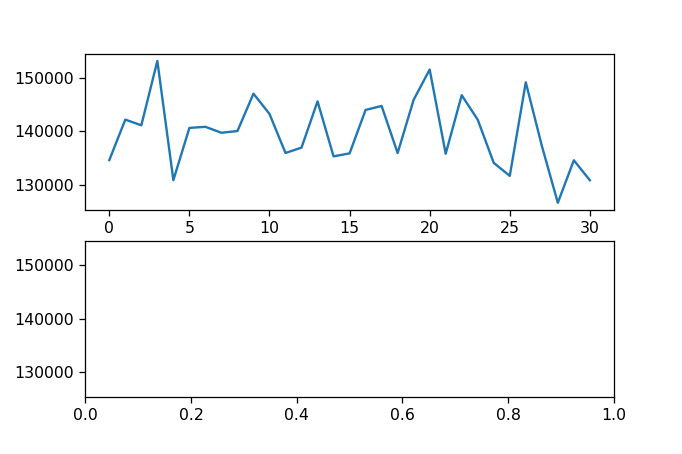

In [21]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

epochs = np.arange(len(train_loss))

fig, (ax1, ax2) = plt.subplots(2,1, sharey=True)
ax1.plot(epochs, train_loss)
#ax2.plot(epochs, train_acc)
fig.show()

In [18]:
import numpy as np
unique, counts = np.unique(xtrainMask, return_counts=True)

print(unique, counts)
print(1-1.)

[0. 1.] [1727250 6137070]
0.0
